# Generating a Neural Network to find the depth of any cube

This file is used to train the artificial neural network with a cube dataset that Kalyane created with more than 4.5 million datapoints, but unfortunatelly cannot be push to GitHub as it is a large file, and generate models that can be used at any time without the need to train the model again. The generated files/models will be in this repository.

## 1. Neural Network to find the depth of any cube

The neural network will be trained with 80% of the data. Will receive any Rubik's cube and output the depth using softmax activation function to find a depth between 1 and 9.

In [48]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

In [49]:
full_dataset = pd.read_csv('new_cube_dataset.csv')  

## 1.1. Creating the training and testing sets

I am going to use the famous sklearn library to divide the dataset, but first, I get only the values of every single row of the datafram, creating then a numpy array that has the same shape of the input layer of my ANN.

In [50]:
from sklearn.model_selection import train_test_split

columns = [ 'cube_'+str(layer)+'_'+str(cubie) for layer in range(6) for cubie in range(9)]

X = full_dataset[columns].values
y = full_dataset["depth"].values

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
X_train[0]

array([3, 0, 0, 3, 0, 0, 5, 5, 5, 2, 2, 4, 1, 1, 4, 1, 1, 4, 3, 4, 4, 0,
       2, 2, 0, 2, 2, 3, 3, 3, 3, 3, 3, 2, 5, 5, 1, 4, 4, 1, 4, 4, 1, 0,
       0, 5, 5, 0, 5, 5, 2, 1, 1, 2], dtype=int64)

In [53]:
# changing classification from (1, 9) to (0, 8)
y_train -= 1
y_test -= 1

In [54]:
y_train[0]

4

## 1.2. Building Neural Network using Keras layers

I am going to create a really simple neural network because the more complexity more time it will take and I don't have much resourses. To do that, I am using the keras tuner to find the "best" hyperparameters as there are many different combinations that could be implemented but not all of them would have good results.

In [55]:
import keras_tuner as kt

def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(54,)))

  # Tune the number of units in the first Dense layer
  num_layers = hp.Int('num_layers', 2, 10)

  for i in range(num_layers):
    # Choose an optimal value between 9-54
    model.add(keras.layers.Dense(units=hp.Int('units_'+str(i), 
                                        min_value=9, 
                                        max_value=54, 
                                        step=15), 
                                        activation=hp.Choice(name = 'activation_'+str(i), 
                                        values = ['relu', 'sigmoid'], ordered = False)))
                                        
  model.add(keras.layers.Dense(9, activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

  return model

In [56]:
# using hyperband to do the random search to get the best combinations first
# then run training and eveluatuion on the best ones
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='cube_mosaic')

INFO:tensorflow:Reloading Oracle from existing project my_dir\cube_mosaic\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\cube_mosaic\tuner0.json


In [62]:
# stopping training if loss havent improved in the last 5 epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, steps_per_epoch=4500, epochs=2, validation_split=0.2, callbacks=[stop_early])

Trial 32 Complete [00h 03m 35s]
val_accuracy: 0.36354029178619385

Best val_accuracy So Far: 0.36354029178619385
Total elapsed time: 01h 21m 47s
INFO:tensorflow:Oracle triggered exit


## 1.3. Training model

I will train the model and save it in case of something and for futures experiments. To train the model, I just need to get the best combinations of the tuner.

In [ ]:
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(bestHP)

In [70]:
# I trained to model with different values for epochs and steps_per_epoch
# it stopped because of me not having memory, then I continued with lower values
history = model.fit(
    X_train, 
    y_train,
    epochs=50, 
    steps_per_epoch=45000,
    validation_split=0.1,
    validation_steps=2,
    callbacks=[stop_early],
    verbose = 1
)

Epoch 1/50
45000/45000 [==============================] - 108s 2ms/step - loss: 1.3311 - accuracy: 0.3934 - val_loss: 1.3340 - val_accuracy: 0.3922
Epoch 2/50
45000/45000 [==============================] - 105s 2ms/step - loss: 1.3300 - accuracy: 0.3942 - val_loss: 1.3259 - val_accuracy: 0.3962
Epoch 3/50
45000/45000 [==============================] - 110s 2ms/step - loss: 1.3290 - accuracy: 0.3943 - val_loss: 1.3312 - val_accuracy: 0.3917
Epoch 4/50
45000/45000 [==============================] - 115s 3ms/step - loss: 1.3282 - accuracy: 0.3945 - val_loss: 1.3283 - val_accuracy: 0.3939
Epoch 5/50
45000/45000 [==============================] - 117s 3ms/step - loss: 1.3276 - accuracy: 0.3947 - val_loss: 1.3248 - val_accuracy: 0.3973
Epoch 6/50
45000/45000 [==============================] - 115s 3ms/step - loss: 1.3269 - accuracy: 0.3949 - val_loss: 1.3268 - val_accuracy: 0.3914
Epoch 7/50
45000/45000 [==============================] - 115s 3ms/step - loss: 1.3265 - accuracy: 0.3951 - val_

In [74]:
# guaranteeing that I will have my model at any point
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [ ]:
# changing name values
model._name = "cube_depth" #Naming model
model.layers[0]._name = 'input'
model.layers[1]._name = 'hidden_layer_1'
model.layers[2]._name = 'hidden_layer_2'
model.layers[3]._name = 'hidden_layer_3'
model.layers[4]._name = 'output'

model.save('saved_model/my_model')

In [10]:
import tensorflow as tf
# checking if it was saved succesfully!
model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
model.summary()

Model: "cube_depth"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 54)                0         
                                                                 
 hidden_layer_1 (Dense)      (None, 39)                2145      
                                                                 
 hidden_layer_2 (Dense)      (None, 54)                2160      
                                                                 
 hidden_layer_3 (Dense)      (None, 54)                2970      
                                                                 
 output (Dense)              (None, 9)                 495       
                                                                 
Total params: 7,770
Trainable params: 7,770
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(x=X_test, batch_size=32)

In [77]:
print(classification_report(y_test,
	predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70     19946
           1       0.54      0.99      0.70     40152
           2       0.47      0.80      0.60     59650
           3       0.44      0.51      0.47     79847
           4       0.35      0.21      0.26     99830
           5       0.32      0.20      0.25    119784
           6       0.31      0.12      0.17    140959
           7       0.34      0.18      0.24    159987
           8       0.37      0.66      0.48    179845

    accuracy                           0.40    900000
   macro avg       0.41      0.52      0.43    900000
weighted avg       0.37      0.40      0.35    900000



In [83]:
accuracy = classification_report(y_test, predictions.argmax(axis=1), output_dict=True)["accuracy"]

Text(0.5, 1.0, 'Accuracy Score: 0.3976588888888889')

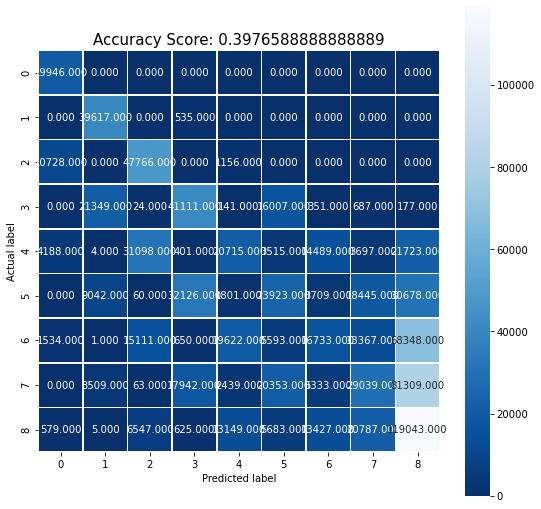

In [84]:
from sklearn import metrics
import seaborn as sns
cm = metrics.confusion_matrix(y_test, predictions.argmax(axis=1))

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15)